<a href="https://colab.research.google.com/github/sowmyamanojna/CS6024-Algorithmic-Approaches-to-Computational-Biology-Project/blob/master/codes/vae_dae/vae_retrial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

%tensorflow_version 1.x
import tensorflow as tf
from keras import backend as K
from keras import optimizers, metrics
from keras.callbacks import Callback
from keras.layers import Input, Dense, Lambda, Activation, Dropout, Layer
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from keras.regularizers import l1

TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# From tybalt.utils.vae_utils
def approx_keras_binary_cross_entropy(x, z, p, epsilon=1e-07):
    """
    Function to approximate Keras `binary_crossentropy()`
    https://github.com/keras-team/keras/blob/e6c3f77b0b10b0d76778109a40d6d3282f1cadd0/keras/losses.py#L76
    Which is a wrapper for TensorFlow `sigmoid_cross_entropy_with_logits()`
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits
    An important step is to clip values of reconstruction
    https://github.com/keras-team/keras/blob/a3d160b9467c99cbb27f9aa0382c759f45c8ee66/keras/backend/tensorflow_backend.py#L3071
    Arguments:
    x - Reconstructed input RNAseq data
    z - Input RNAseq data
    p - number of features
    epsilon - the clipping value to stabilize results (same Keras default)
    """
    # Ensure numpy arrays
    x = np.array(x)
    z = np.array(z)

    # Add clip to value
    x[x < epsilon] = epsilon
    x[x > (1 - epsilon)] = (1 - epsilon)

    # Perform logit
    x = np.log(x / (1 - x))

    # Return approximate binary cross entropy
    return np.mean(p * np.mean(- x * z + np.log(1 + np.exp(x)), axis=-1))


class VariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training
    """
    def __init__(self, var_layer, mean_layer, original_dim, beta, loss,
                 **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        self.var_layer = var_layer
        self.mean_layer = mean_layer
        self.original_dim = original_dim
        self.beta = beta
        self.loss = loss
        super(VariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        if self.loss == 'binary_crossentropy':
            recon_loss = self.original_dim * \
                         metrics.binary_crossentropy(x_input, x_decoded)
        elif self.loss == 'mse':
            recon_loss = self.original_dim * \
                         metrics.mean_squared_error(x_input, x_decoded)

        kl_loss = - 0.5 * K.sum(1 + self.var_layer -
                                K.square(self.mean_layer) -
                                K.exp(self.var_layer), axis=-1)

        return K.mean(recon_loss + (K.get_value(self.beta) * kl_loss))

    def call(self, inputs):
        x, x_decoded = inputs
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x


class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa

    def on_epoch_end(self, epoch, logs={}):
        """
        Behavior on each epoch
        """
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)


class LossCallback(Callback):
    def __init__(self, training_data, original_dim, encoder_cbk, decoder_cbk):
        self.training_data = training_data
        self.original_dim = original_dim
        self.encoder_cbk = encoder_cbk
        self.decoder_cbk = decoder_cbk

    def on_train_begin(self, logs={}):
        self.xent_loss = []
        self.kl_loss = []

    def on_epoch_end(self, epoch, logs={}):
        recon = self.decoder_cbk.predict(
            self.encoder_cbk.predict(self.training_data))
        xent_loss = approx_keras_binary_cross_entropy(x=recon,
                                                      z=self.training_data,
                                                      p=self.original_dim)
        full_loss = logs.get('loss')
        self.xent_loss.append(xent_loss)
        self.kl_loss.append(full_loss - xent_loss)
        return

In [4]:
# From tybalt.utils.base
from keras.utils import plot_model


class BaseModel():
    def __init__(self):
        pass

    def get_summary(self):
        self.full_model.summary()

    def visualize_architecture(self, output_file):
        # Visualize the connections of the custom VAE model
        plot_model(self.full_model, to_file=output_file)

    def visualize_training(self, output_file=None):
        # Visualize training performance
        history_df = pd.DataFrame(self.hist.history)
        ax = history_df.plot()
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        fig = ax.get_figure()
        if output_file:
            fig.savefig(output_file)
        else:
            fig.show()

    def get_weights(self, decoder=True):
        # Extract weight matrices from encoder or decoder
        weights = []
        if decoder:
            for layer in self.decoder.layers:
                weights.append(layer.get_weights())
        else:
            for layer in self.encoder.layers:
                # Encoder weights must be transposed
                encoder_weights = layer.get_weights()
                encoder_weights = [np.transpose(x) for x in encoder_weights]
                weights.append(encoder_weights)
        return weights

    def save_models(self, encoder_file, decoder_file):
        self.encoder.save(encoder_file)
        self.decoder.save(decoder_file)


class VAE(BaseModel):
    def __init__(self):
        BaseModel.__init__(self)

    def _sampling(self, args):
        """
        Function for reparameterization trick to make model differentiable
        """
        # Function with args required for Keras Lambda function
        z_mean, z_log_var = args

        # Draw epsilon of the same shape from a standard normal distribution
        epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                                  stddev=self.epsilon_std)

        # The latent vector is non-deterministic and differentiable
        # in respect to z_mean and z_log_var
        z = z_mean + K.exp(z_log_var / 2) * epsilon
        return z

    def initialize_model(self):
        """
        Helper function to run that builds and compiles Keras layers
        """
        self._build_encoder_layer()
        self._build_decoder_layer()
        self._compile_vae()
        self._connect_layers()

    def compress(self, df):
        # Encode rnaseq into the hidden/latent representation - and save output
        # a cVAE expects a list of [rnaseq_df, y_df]
        encoded_df = self.encoder.predict_on_batch(df)

        if self.model_name == 'cTybalt':
            named_index = df[0].index
        else:
            named_index = df.index

        encoded_df = pd.DataFrame(encoded_df,
                                  columns=range(1, self.latent_dim + 1),
                                  index=named_index)
        return encoded_df

In [6]:
class Tybalt(VAE):
    """
    Training and evaluation of a tybalt model
    Usage: from tybalt.models import Tybalt
    """
    def __init__(self, original_dim, latent_dim, batch_size=50, epochs=50,
                 learning_rate=0.0005, kappa=1, epsilon_std=1.0,
                 beta=K.variable(0), loss='binary_crossentropy',
                 verbose=True):
        VAE.__init__(self)
        self.model_name = 'Tybalt'
        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.kappa = kappa
        self.epsilon_std = epsilon_std
        self.beta = beta
        self.loss = loss
        self.verbose = verbose

    def _build_encoder_layer(self):
        """
        Function to build the encoder layer connections
        """
        # Input place holder for RNAseq data with specific input size
        self.rnaseq_input = Input(shape=(self.original_dim, ))

        # Input layer is compressed into a mean and log variance vector of
        # size `latent_dim`. Each layer is initialized with glorot uniform
        # weights and each step (dense connections, batch norm, and relu
        # activation) are funneled separately.
        # Each vector are connected to the rnaseq input tensor

        # input layer to latent mean layer
        z_mean = Dense(self.latent_dim,
                       kernel_initializer='glorot_uniform')(self.rnaseq_input)
        z_mean_batchnorm = BatchNormalization()(z_mean)
        self.z_mean_encoded = Activation('relu')(z_mean_batchnorm)

        # input layer to latent standard deviation layer
        z_var = Dense(self.latent_dim,
                      kernel_initializer='glorot_uniform')(self.rnaseq_input)
        z_var_batchnorm = BatchNormalization()(z_var)
        self.z_var_encoded = Activation('relu')(z_var_batchnorm)

        # return the encoded and randomly sampled z vector
        # Takes two keras layers as input to the custom sampling function layer
        self.z = Lambda(self._sampling,
                        output_shape=(self.latent_dim, ))([self.z_mean_encoded,
                                                           self.z_var_encoded])

    def _build_decoder_layer(self):
        """
        Function to build the decoder layer connections
        """
        # The decoding layer is much simpler with a single layer glorot uniform
        # initialized and sigmoid activation
        self.decoder_model = Sequential()
        self.decoder_model.add(Dense(self.original_dim, activation='sigmoid',
                                     input_dim=self.latent_dim))
        self.rnaseq_reconstruct = self.decoder_model(self.z)

    def _compile_vae(self):
        """
        Creates the vae layer and compiles all layer connections
        """
        adam = optimizers.Adam(lr=self.learning_rate)
        vae_layer = VariationalLayer(var_layer=self.z_var_encoded,
                                     mean_layer=self.z_mean_encoded,
                                     original_dim=self.original_dim,
                                     beta=self.beta, loss=self.loss)(
                                [self.rnaseq_input, self.rnaseq_reconstruct])
        self.full_model = Model(self.rnaseq_input, vae_layer)
        self.full_model.compile(optimizer=adam, loss=None,
                                loss_weights=[self.beta])

    def _connect_layers(self):
        """
        Make connections between layers to build separate encoder and decoder
        """
        self.encoder = Model(self.rnaseq_input, self.z_mean_encoded)

        decoder_input = Input(shape=(self.latent_dim, ))
        _x_decoded_mean = self.decoder_model(decoder_input)
        self.decoder = Model(decoder_input, _x_decoded_mean)

    def train_vae(self, train_df, test_df, separate_loss=False):
        """
        Method to train model.
        `separate_loss` instantiates a custom Keras callback that tracks the
        separate contribution of reconstruction and KL divergence loss. Because
        VAEs try to minimize both, it may be informative to track each across
        training separately. The callback processes the training data through
        the current encoder and decoder and therefore requires additional time
        - which is why this is not done by default.
        """
        cbks = [WarmUpCallback(self.beta, self.kappa)]
        if separate_loss:
            tybalt_loss_cbk = LossCallback(training_data=np.array(train_df),
                                           encoder_cbk=self.encoder,
                                           decoder_cbk=self.decoder,
                                           original_dim=self.original_dim)
            cbks += [tybalt_loss_cbk]

        self.hist = self.full_model.fit(np.array(train_df),
                                        shuffle=True,
                                        epochs=self.epochs,
                                        batch_size=self.batch_size,
                                        verbose=self.verbose,
                                        validation_data=(np.array(test_df),
                                                         None),
                                        callbacks=cbks)
        self.history_df = pd.DataFrame(self.hist.history)

        if separate_loss:
            self.history_df = self.history_df.assign(
                                recon=tybalt_loss_cbk.xent_loss)
            self.history_df = self.history_df.assign(
                                kl=tybalt_loss_cbk.kl_loss)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
pcos_df = pd.read_csv('/content/drive/MyDrive/aacb_project/datasets/common_normalized.csv', index_col=0)
pcos_df = pcos_df.drop(["sample_id", "PCOS"], axis=1)

# Split 10% test set randomly
test_set_percent = 0.1

pcos_test_df = pcos_df.sample(frac=test_set_percent)
pcos_train_df = pcos_df.drop(pcos_test_df.index)

display(pcos_train_df.head(2))
display(pcos_test_df.head(2))

original_dim = pcos_df.shape[1]

,27,36,59,87,94,105,153,159,164,226,288,290,311,330,334,335,345,355,359,377,382,389,392,394,405,408,420,430,443,463,476,487,488,515,533,552,567,572,582,586,...,4718_100532726,92558,92815,92822,93164,93487,93974,6248_84301,8693_100528030,100506581,112399,112479,374655,375035,375057,113251,114088,114791,114882,116228,116285,116985,116986,51463_653519,118491,118987,120227,645644,100129482,100529257_55333,253512,122704,253959,254359,254531,100132341,387893,388336,259266,261726
0,0.693258,0.125461,0.336077,0.044463,0.267819,0.467742,0.490196,0.008907,0.370576,0.953515,0.0000,0.060236,0.230814,0.078014,0.119300,1.0,1.000000,0.000000,0.712054,0.648867,0.535433,0.593551,0.651320,0.000000,0.000000,1.000000,0.132791,1.0,0.000000,0.263318,0.725872,0.701149,0.395953,0.302829,0.839330,0.349876,0.835372,0.502399,0.800414,0.000000,...,1.000000,1.000000,0.609797,0.146067,0.064516,0.915703,0.768041,0.925659,0.000000,0.855740,0.130112,0.000000,1.000000,0.086751,0.288095,0.000000,0.560748,0.965517,0.000000,0.121212,0.000000,1.000000,0.261745,0.209231,0.061603,0.295745,0.489703,0.481948,0.113924,0.100254,0.000000,0.369072,0.000000,0.39619,1.000000,0.412466,0.000000,0.312354,0.198387,0.120213
1,0.214607,0.487085,0.589704,0.104294,0.000000,0.106452,0.000000,0.631829,0.476058,1.000000,0.0409,0.038093,0.799387,0.131206,0.118719,0.0,0.025316,0.216724,0.023437,0.286346,0.619005,0.946925,0.854954,0.337931,0.352278,0.149398,0.636856,0.0,0.184211,0.238965,0.808785,0.609195,0.561854,0.916302,0.265155,0.285360,0.808202,0.291843,0.515512,0.084831,...,0.546667,0.677019,0.142455,0.070225,0.129032,0.512184,0.694845,0.000000,0.536028,0.937385,0.000000,0.809129,0.158155,0.586751,0.424603,0.644419,1.000000,0.000000,0.949077,0.994318,0.085938,0.427987,0.049664,0.763077,0.000000,1.000000,0.080092,0.000000,0.082278,0.407360,0.418699,0.437113,0.367855,0.56419,0.497418,0.325390,0.356499,0.173660,0.430645,1.000000


,27,36,59,87,94,105,153,159,164,226,288,290,311,330,334,335,345,355,359,377,382,389,392,394,405,408,420,430,443,463,476,487,488,515,533,552,567,572,582,586,...,4718_100532726,92558,92815,92822,93164,93487,93974,6248_84301,8693_100528030,100506581,112399,112479,374655,375035,375057,113251,114088,114791,114882,116228,116285,116985,116986,51463_653519,118491,118987,120227,645644,100129482,100529257_55333,253512,122704,253959,254359,254531,100132341,387893,388336,259266,261726
113,0.567749,0.461017,0.474936,0.433330,0.179377,0.246117,0.898842,1.000000,0.281240,0.054420,0.276878,0.810794,0.091615,0.147312,0.557918,1.000000,0.539273,0.00000,0.611899,0.004290,0.718175,0.030154,0.156186,0.161084,0.483833,0.69855,0.089829,0.503792,1.000000,0.203078,0.147251,0.000000,0.523888,0.583420,0.328768,0.576160,0.522413,0.700096,0.117974,0.0,...,0.515002,0.337710,0.694128,0.335356,0.873402,0.343310,0.339877,0.4728,0.092957,0.960953,0.127420,0.361070,0.808714,0.321723,0.154081,0.605265,0.142918,0.555709,0.462497,0.325473,1.000000,0.713442,0.463011,0.152040,0.287976,0.191007,0.416869,0.469733,0.296721,0.407778,0.328666,0.069067,0.469498,0.379900,0.479917,0.000000,0.322999,0.309633,0.082538,0.18970
55,0.883201,0.631997,0.341532,0.240808,0.732292,0.838656,0.614461,0.533513,0.486213,0.516949,1.000000,1.000000,0.870871,0.650494,0.368217,0.814072,1.000000,0.72075,0.926398,0.908674,0.702343,0.683469,0.092103,0.439145,0.858194,1.00000,0.000000,0.950966,0.526461,0.325182,0.000000,0.498005,0.259636,0.441159,0.593770,0.407538,0.209806,0.022316,0.701737,0.0,...,0.688879,0.084264,0.793225,0.000000,0.030891,0.533552,0.366577,1.0000,0.088736,0.880417,0.206302,0.812944,0.709895,0.561586,0.325223,0.232439,0.741635,0.874992,0.375780,0.316307,0.127429,0.435443,0.476510,0.295671,0.000000,0.336402,0.868756,1.000000,0.159826,0.839162,0.538111,1.000000,0.793231,0.345549,0.034524,0.832429,0.508737,0.965518,0.408621,0.93319


In [9]:
# Setting up the possible latent dimensions
# A total of 26 latent dimensions are taken under consideration

k_list = []
k_list.extend(list(range(2, 10)))
k_list.extend(list(range(10, 20, 2)))
k_list.extend(list(range(20, 50, 5)))
k_list.extend(list(range(50, 61, 10)))
k_list.append(78)
k_list.extend(list(range(80, 100, 10)))
k_list.extend(list(range(100, 151, 25)))

print("Latent dimensions:")
print(k_list)

Latent dimensions:
[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50, 60, 78, 80, 90, 100, 125, 150]


tracking <tf.Variable 'Variable_2:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_2 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_2.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 1s 4ms/step - loss: 1156.2013 - val_loss: 1155.6187
Epoch 2/200
157/157 [==============================] - 0s 223us/step - loss: 1153.7412 - val_loss: 1155.6162
Epoch 3/200
157/157 [==============================] - 0s 223us/step - loss: 1151.5672 - val_loss: 1154.1356
Epoch 4/200
157/157 [==============================] - 0s 210us/step - loss: 1149.5122 - val_loss: 1155.4155
Epoch 5/200
157/157 [==============================] - 0s 201us/step - loss: 1147.7174 - val_loss: 1155.5131
Epoch 6/200
157/157 [==============================] - 0s 258us/step - loss: 1146.0898 - val_loss: 1152.7631
Epoch 7/200
157/157 [==============================] - 0s 288us/step - loss: 1144.2024 - val_loss: 1152.0895
Epoch 8/200
157/157 [==============================] - 0s 218us/step - loss: 1143.9686 - val_loss: 1153.6357
Epoch 9/200
157/157 [==============================] - 0s 221us/step - loss: 1140.478

<Figure size 432x288 with 0 Axes>

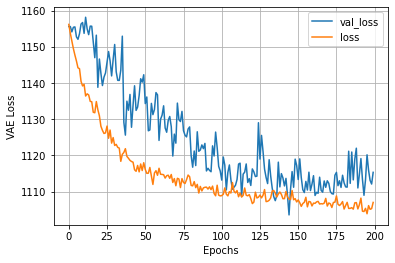

tracking <tf.Variable 'Variable_3:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_3 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_3.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 1s 5ms/step - loss: 1156.6193 - val_loss: 1166.8657
Epoch 2/200
157/157 [==============================] - 0s 248us/step - loss: 1154.7579 - val_loss: 1171.8685
Epoch 3/200
157/157 [==============================] - 0s 262us/step - loss: 1152.1789 - val_loss: 1192.8857
Epoch 4/200
157/157 [==============================] - 0s 219us/step - loss: 1149.4489 - val_loss: 1243.9517
Epoch 5/200
157/157 [==============================] - 0s 236us/step - loss: 1146.7765 - val_loss: 1355.5991
Epoch 6/200
157/157 [==============================] - 0s 198us/step - loss: 1145.6247 - val_loss: 1521.3352
Epoch 7/200
157/157 [==============================] - 0s 203us/step - loss: 1143.4187 - val_loss: 1452.5786
Epoch 8/200
157/157 [==============================] - 0s 231us/step - loss: 1140.2079 - val_loss: 1370.7397
Epoch 9/200
157/157 [==============================] - 0s 210us/step - loss: 1139.690

<Figure size 432x288 with 0 Axes>

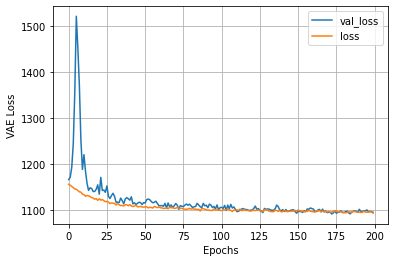

tracking <tf.Variable 'Variable_4:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_4 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_4.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 1s 5ms/step - loss: 1157.0214 - val_loss: 1164.4738
Epoch 2/200
157/157 [==============================] - 0s 255us/step - loss: 1153.9843 - val_loss: 1181.7485
Epoch 3/200
157/157 [==============================] - 0s 235us/step - loss: 1150.4345 - val_loss: 1238.6576
Epoch 4/200
157/157 [==============================] - 0s 234us/step - loss: 1146.2300 - val_loss: 1199.1073
Epoch 5/200
157/157 [==============================] - 0s 212us/step - loss: 1144.2586 - val_loss: 1280.9701
Epoch 6/200
157/157 [==============================] - 0s 219us/step - loss: 1141.8566 - val_loss: 1407.9985
Epoch 7/200
157/157 [==============================] - 0s 207us/step - loss: 1139.5562 - val_loss: 1731.8705
Epoch 8/200
157/157 [==============================] - 0s 219us/step - loss: 1136.3000 - val_loss: 1567.2742
Epoch 9/200
157/157 [==============================] - 0s 234us/step - loss: 1133.163

<Figure size 432x288 with 0 Axes>

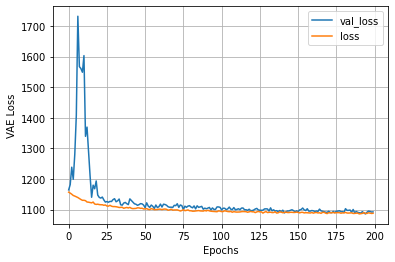

tracking <tf.Variable 'Variable_5:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_5 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_5.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 1s 6ms/step - loss: 1157.4358 - val_loss: 1158.7601
Epoch 2/200
157/157 [==============================] - 0s 233us/step - loss: 1153.6151 - val_loss: 1168.0889
Epoch 3/200
157/157 [==============================] - 0s 251us/step - loss: 1150.4199 - val_loss: 1180.1003
Epoch 4/200
157/157 [==============================] - 0s 214us/step - loss: 1147.5776 - val_loss: 1169.9227
Epoch 5/200
157/157 [==============================] - 0s 238us/step - loss: 1142.8263 - val_loss: 1224.9656
Epoch 6/200
157/157 [==============================] - 0s 224us/step - loss: 1139.5323 - val_loss: 1191.0209
Epoch 7/200
157/157 [==============================] - 0s 226us/step - loss: 1137.7572 - val_loss: 1244.3593
Epoch 8/200
157/157 [==============================] - 0s 208us/step - loss: 1134.8402 - val_loss: 1343.9546
Epoch 9/200
157/157 [==============================] - 0s 228us/step - loss: 1131.450

<Figure size 432x288 with 0 Axes>

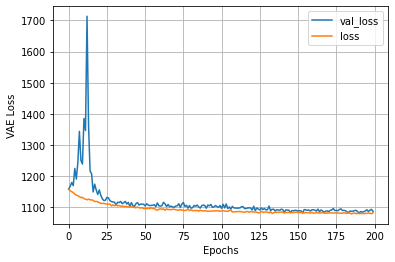

tracking <tf.Variable 'Variable_6:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_6 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_6.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 1s 7ms/step - loss: 1157.6171 - val_loss: 1158.2603
Epoch 2/200
157/157 [==============================] - 0s 268us/step - loss: 1153.4628 - val_loss: 1241.3396
Epoch 3/200
157/157 [==============================] - 0s 251us/step - loss: 1149.4074 - val_loss: 1357.2407
Epoch 4/200
157/157 [==============================] - 0s 219us/step - loss: 1145.3638 - val_loss: 1414.8236
Epoch 5/200
157/157 [==============================] - 0s 223us/step - loss: 1142.5323 - val_loss: 1725.6531
Epoch 6/200
157/157 [==============================] - 0s 262us/step - loss: 1137.5895 - val_loss: 2500.4834
Epoch 7/200
157/157 [==============================] - 0s 220us/step - loss: 1133.7811 - val_loss: 2526.7126
Epoch 8/200
157/157 [==============================] - 0s 213us/step - loss: 1134.0288 - val_loss: 1815.5693
Epoch 9/200
157/157 [==============================] - 0s 268us/step - loss: 1128.895

<Figure size 432x288 with 0 Axes>

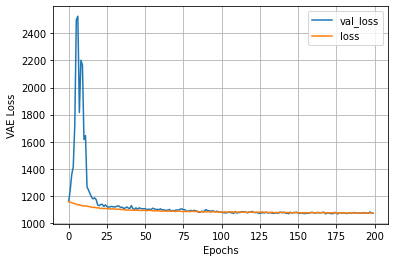

tracking <tf.Variable 'Variable_7:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_7 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_7.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 1s 8ms/step - loss: 1158.5790 - val_loss: 1171.5409
Epoch 2/200
157/157 [==============================] - 0s 251us/step - loss: 1154.3088 - val_loss: 1240.7974
Epoch 3/200
157/157 [==============================] - 0s 240us/step - loss: 1149.4137 - val_loss: 1444.6964
Epoch 4/200
157/157 [==============================] - 0s 292us/step - loss: 1144.3588 - val_loss: 1386.4453
Epoch 5/200
157/157 [==============================] - 0s 223us/step - loss: 1141.2776 - val_loss: 1237.8528
Epoch 6/200
157/157 [==============================] - 0s 221us/step - loss: 1136.7620 - val_loss: 1399.9641
Epoch 7/200
157/157 [==============================] - 0s 221us/step - loss: 1133.9906 - val_loss: 1276.6421
Epoch 8/200
157/157 [==============================] - 0s 211us/step - loss: 1130.2255 - val_loss: 1232.2990
Epoch 9/200
157/157 [==============================] - 0s 219us/step - loss: 1127.154

<Figure size 432x288 with 0 Axes>

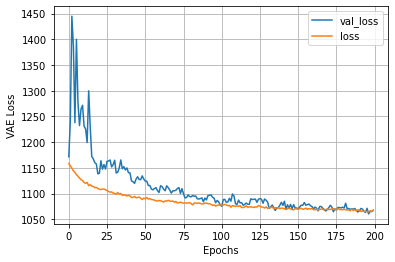

tracking <tf.Variable 'Variable_8:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_8 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_8.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 1s 9ms/step - loss: 1159.0487 - val_loss: 1168.7645
Epoch 2/200
157/157 [==============================] - 0s 261us/step - loss: 1153.6412 - val_loss: 1178.2162
Epoch 3/200
157/157 [==============================] - 0s 227us/step - loss: 1149.1131 - val_loss: 1202.9143
Epoch 4/200
157/157 [==============================] - 0s 264us/step - loss: 1144.9463 - val_loss: 1248.7003
Epoch 5/200
157/157 [==============================] - 0s 237us/step - loss: 1139.0133 - val_loss: 1238.1974
Epoch 6/200
157/157 [==============================] - 0s 239us/step - loss: 1134.8439 - val_loss: 1260.7710
Epoch 7/200
157/157 [==============================] - 0s 263us/step - loss: 1130.1247 - val_loss: 1207.6152
Epoch 8/200
157/157 [==============================] - 0s 321us/step - loss: 1127.7845 - val_loss: 1173.5983
Epoch 9/200
157/157 [==============================] - 0s 264us/step - loss: 1125.222

<Figure size 432x288 with 0 Axes>

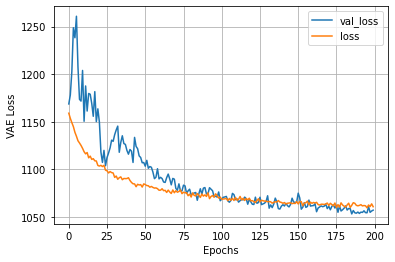

tracking <tf.Variable 'Variable_9:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_9 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_9.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 2s 10ms/step - loss: 1160.1500 - val_loss: 1168.2693
Epoch 2/200
157/157 [==============================] - 0s 292us/step - loss: 1154.6358 - val_loss: 1196.3083
Epoch 3/200
157/157 [==============================] - 0s 236us/step - loss: 1149.4310 - val_loss: 1285.9030
Epoch 4/200
157/157 [==============================] - 0s 259us/step - loss: 1144.8217 - val_loss: 1307.6650
Epoch 5/200
157/157 [==============================] - 0s 250us/step - loss: 1140.4238 - val_loss: 1318.1387
Epoch 6/200
157/157 [==============================] - 0s 250us/step - loss: 1135.8807 - val_loss: 1339.1141
Epoch 7/200
157/157 [==============================] - 0s 254us/step - loss: 1133.3883 - val_loss: 1222.4364
Epoch 8/200
157/157 [==============================] - 0s 226us/step - loss: 1130.7471 - val_loss: 1257.7161
Epoch 9/200
157/157 [==============================] - 0s 246us/step - loss: 1125.33

<Figure size 432x288 with 0 Axes>

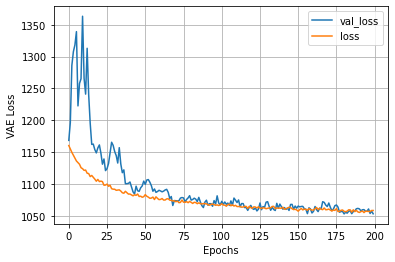

tracking <tf.Variable 'Variable_10:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_10 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_10.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 2s 11ms/step - loss: 1159.5199 - val_loss: 1169.1772
Epoch 2/200
157/157 [==============================] - 0s 278us/step - loss: 1153.3706 - val_loss: 1185.2335
Epoch 3/200
157/157 [==============================] - 0s 264us/step - loss: 1147.3650 - val_loss: 1263.3940
Epoch 4/200
157/157 [==============================] - 0s 286us/step - loss: 1140.9361 - val_loss: 1262.1017
Epoch 5/200
157/157 [==============================] - 0s 254us/step - loss: 1135.3939 - val_loss: 1296.1523
Epoch 6/200
157/157 [==============================] - 0s 275us/step - loss: 1131.8941 - val_loss: 1528.1158
Epoch 7/200
157/157 [==============================] - 0s 250us/step - loss: 1127.2335 - val_loss: 1213.5312
Epoch 8/200
157/157 [==============================] - 0s 257us/step - loss: 1123.6549 - val_loss: 1561.7975
Epoch 9/200
157/157 [==============================] - 0s 244us/step - loss: 1121.06

<Figure size 432x288 with 0 Axes>

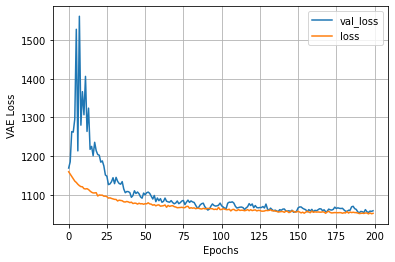

tracking <tf.Variable 'Variable_11:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_11 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_11.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 2s 12ms/step - loss: 1160.7638 - val_loss: 1163.4967
Epoch 2/200
157/157 [==============================] - 0s 321us/step - loss: 1153.2357 - val_loss: 1190.9043
Epoch 3/200
157/157 [==============================] - 0s 269us/step - loss: 1145.9963 - val_loss: 1302.3179
Epoch 4/200
157/157 [==============================] - 0s 260us/step - loss: 1139.4672 - val_loss: 1366.0181
Epoch 5/200
157/157 [==============================] - 0s 256us/step - loss: 1135.1083 - val_loss: 2235.3696
Epoch 6/200
157/157 [==============================] - 0s 317us/step - loss: 1130.6353 - val_loss: 2084.9905
Epoch 7/200
157/157 [==============================] - 0s 280us/step - loss: 1123.8402 - val_loss: 2903.8271
Epoch 8/200
157/157 [==============================] - 0s 264us/step - loss: 1121.0587 - val_loss: 2293.5991
Epoch 9/200
157/157 [==============================] - 0s 276us/step - loss: 1119.33

<Figure size 432x288 with 0 Axes>

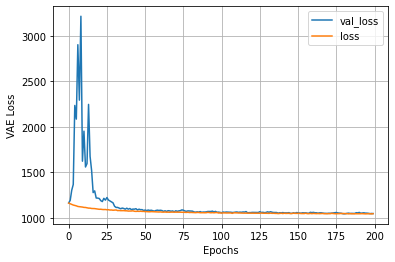

tracking <tf.Variable 'Variable_12:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_12 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_12.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 2s 13ms/step - loss: 1162.0022 - val_loss: 1202.5442
Epoch 2/200
157/157 [==============================] - 0s 302us/step - loss: 1154.5406 - val_loss: 1352.7233
Epoch 3/200
157/157 [==============================] - 0s 253us/step - loss: 1145.0798 - val_loss: 1548.1576
Epoch 4/200
157/157 [==============================] - 0s 324us/step - loss: 1139.9737 - val_loss: 1598.3823
Epoch 5/200
157/157 [==============================] - 0s 253us/step - loss: 1130.9169 - val_loss: 1422.3091
Epoch 6/200
157/157 [==============================] - 0s 250us/step - loss: 1126.2126 - val_loss: 1627.5905
Epoch 7/200
157/157 [==============================] - 0s 291us/step - loss: 1124.5920 - val_loss: 1519.5984
Epoch 8/200
157/157 [==============================] - 0s 292us/step - loss: 1122.1595 - val_loss: 1438.7142
Epoch 9/200
157/157 [==============================] - 0s 335us/step - loss: 1116.00

<Figure size 432x288 with 0 Axes>

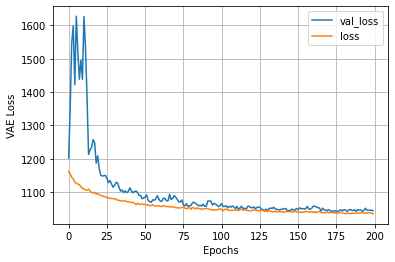

tracking <tf.Variable 'Variable_13:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_13 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_13.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 2s 14ms/step - loss: 1162.7588 - val_loss: 1190.8013
Epoch 2/200
157/157 [==============================] - 0s 287us/step - loss: 1154.2991 - val_loss: 1478.0623
Epoch 3/200
157/157 [==============================] - 0s 259us/step - loss: 1144.4771 - val_loss: 1834.9349
Epoch 4/200
157/157 [==============================] - 0s 261us/step - loss: 1135.2670 - val_loss: 2558.7249
Epoch 5/200
157/157 [==============================] - 0s 266us/step - loss: 1129.7661 - val_loss: 2470.0806
Epoch 6/200
157/157 [==============================] - 0s 306us/step - loss: 1126.0203 - val_loss: 2477.3887
Epoch 7/200
157/157 [==============================] - 0s 367us/step - loss: 1123.5607 - val_loss: 2636.1963
Epoch 8/200
157/157 [==============================] - 0s 262us/step - loss: 1115.8877 - val_loss: 2265.5308
Epoch 9/200
157/157 [==============================] - 0s 270us/step - loss: 1111.48

<Figure size 432x288 with 0 Axes>

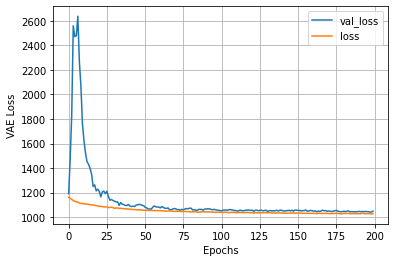

tracking <tf.Variable 'Variable_14:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_14 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_14.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 2s 14ms/step - loss: 1163.8218 - val_loss: 1176.1252
Epoch 2/200
157/157 [==============================] - 0s 335us/step - loss: 1152.5064 - val_loss: 1221.9485
Epoch 3/200
157/157 [==============================] - 0s 287us/step - loss: 1144.0705 - val_loss: 1274.8925
Epoch 4/200
157/157 [==============================] - 0s 286us/step - loss: 1134.5037 - val_loss: 1374.5244
Epoch 5/200
157/157 [==============================] - 0s 274us/step - loss: 1126.4035 - val_loss: 1460.8188
Epoch 6/200
157/157 [==============================] - 0s 286us/step - loss: 1122.3317 - val_loss: 1762.1034
Epoch 7/200
157/157 [==============================] - 0s 294us/step - loss: 1118.1737 - val_loss: 1665.0841
Epoch 8/200
157/157 [==============================] - 0s 257us/step - loss: 1114.7325 - val_loss: 1699.5068
Epoch 9/200
157/157 [==============================] - 0s 296us/step - loss: 1112.31

<Figure size 432x288 with 0 Axes>

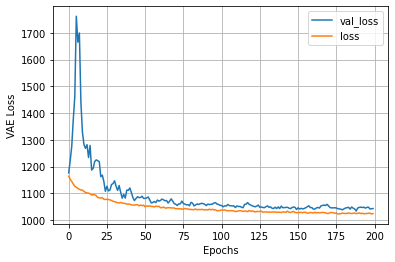

tracking <tf.Variable 'Variable_15:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_15 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_15.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 2s 15ms/step - loss: 1165.2189 - val_loss: 1178.2827
Epoch 2/200
157/157 [==============================] - 0s 306us/step - loss: 1153.3898 - val_loss: 1253.4528
Epoch 3/200
157/157 [==============================] - 0s 284us/step - loss: 1142.9448 - val_loss: 1338.3990
Epoch 4/200
157/157 [==============================] - 0s 281us/step - loss: 1130.8578 - val_loss: 1461.3145
Epoch 5/200
157/157 [==============================] - 0s 295us/step - loss: 1125.5694 - val_loss: 1579.0121
Epoch 6/200
157/157 [==============================] - 0s 278us/step - loss: 1123.8605 - val_loss: 1497.0344
Epoch 7/200
157/157 [==============================] - 0s 287us/step - loss: 1117.2545 - val_loss: 1894.4253
Epoch 8/200
157/157 [==============================] - 0s 306us/step - loss: 1113.3289 - val_loss: 1658.9359
Epoch 9/200
157/157 [==============================] - 0s 297us/step - loss: 1112.53

<Figure size 432x288 with 0 Axes>

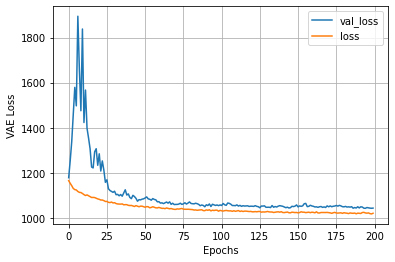

tracking <tf.Variable 'Variable_16:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_16 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_16.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 2s 16ms/step - loss: 1166.4725 - val_loss: 1180.4111
Epoch 2/200
157/157 [==============================] - 0s 326us/step - loss: 1153.0409 - val_loss: 1214.1909
Epoch 3/200
157/157 [==============================] - 0s 302us/step - loss: 1142.3329 - val_loss: 1284.5983
Epoch 4/200
157/157 [==============================] - 0s 302us/step - loss: 1129.2161 - val_loss: 1441.5269
Epoch 5/200
157/157 [==============================] - 0s 311us/step - loss: 1126.1307 - val_loss: 1651.6599
Epoch 6/200
157/157 [==============================] - 0s 273us/step - loss: 1117.8365 - val_loss: 1363.1146
Epoch 7/200
157/157 [==============================] - 0s 283us/step - loss: 1112.3325 - val_loss: 1515.3059
Epoch 8/200
157/157 [==============================] - 0s 285us/step - loss: 1107.9256 - val_loss: 1610.6929
Epoch 9/200
157/157 [==============================] - 0s 330us/step - loss: 1104.07

<Figure size 432x288 with 0 Axes>

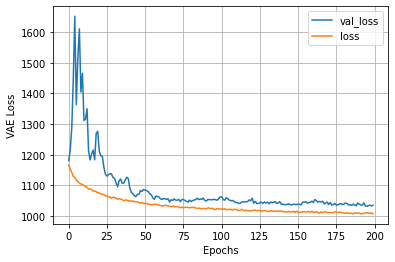

tracking <tf.Variable 'Variable_17:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_17 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_17.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 3s 17ms/step - loss: 1169.7627 - val_loss: 1199.6674
Epoch 2/200
157/157 [==============================] - 0s 322us/step - loss: 1155.7834 - val_loss: 1284.7213
Epoch 3/200
157/157 [==============================] - 0s 305us/step - loss: 1143.0555 - val_loss: 1364.1992
Epoch 4/200
157/157 [==============================] - 0s 296us/step - loss: 1132.3953 - val_loss: 1706.7727
Epoch 5/200
157/157 [==============================] - 0s 306us/step - loss: 1123.6223 - val_loss: 2012.9878
Epoch 6/200
157/157 [==============================] - 0s 361us/step - loss: 1117.1660 - val_loss: 1716.4459
Epoch 7/200
157/157 [==============================] - 0s 290us/step - loss: 1112.7318 - val_loss: 1846.2739
Epoch 8/200
157/157 [==============================] - 0s 289us/step - loss: 1108.9192 - val_loss: 1676.5986
Epoch 9/200
157/157 [==============================] - 0s 310us/step - loss: 1103.28

<Figure size 432x288 with 0 Axes>

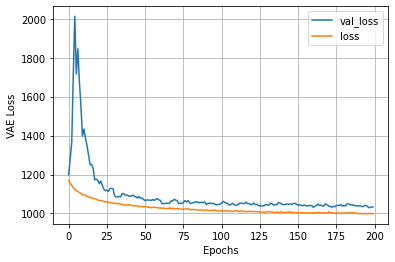

tracking <tf.Variable 'Variable_18:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_18 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_18.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 3s 17ms/step - loss: 1172.1130 - val_loss: 1220.2682
Epoch 2/200
157/157 [==============================] - 0s 378us/step - loss: 1154.8704 - val_loss: 1545.2823
Epoch 3/200
157/157 [==============================] - 0s 318us/step - loss: 1140.1971 - val_loss: 1956.5684
Epoch 4/200
157/157 [==============================] - 0s 345us/step - loss: 1128.2355 - val_loss: 2316.0017
Epoch 5/200
157/157 [==============================] - 0s 340us/step - loss: 1120.3221 - val_loss: 2222.8599
Epoch 6/200
157/157 [==============================] - 0s 339us/step - loss: 1116.2725 - val_loss: 2512.3977
Epoch 7/200
157/157 [==============================] - 0s 324us/step - loss: 1109.4916 - val_loss: 2368.3481
Epoch 8/200
157/157 [==============================] - 0s 394us/step - loss: 1102.9718 - val_loss: 2426.2700
Epoch 9/200
157/157 [==============================] - 0s 381us/step - loss: 1097.66

<Figure size 432x288 with 0 Axes>

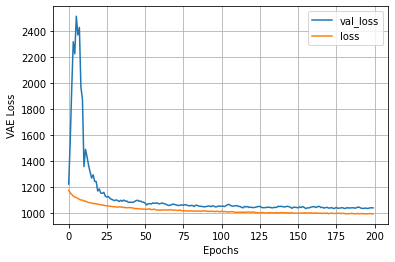

tracking <tf.Variable 'Variable_19:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_19 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_19.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 3s 18ms/step - loss: 1173.9338 - val_loss: 1209.0278
Epoch 2/200
157/157 [==============================] - 0s 398us/step - loss: 1154.0088 - val_loss: 1350.7443
Epoch 3/200
157/157 [==============================] - 0s 342us/step - loss: 1137.7494 - val_loss: 1589.0167
Epoch 4/200
157/157 [==============================] - 0s 340us/step - loss: 1125.0119 - val_loss: 1415.7096
Epoch 5/200
157/157 [==============================] - 0s 386us/step - loss: 1118.0332 - val_loss: 1765.6157
Epoch 6/200
157/157 [==============================] - 0s 384us/step - loss: 1110.7606 - val_loss: 1442.6061
Epoch 7/200
157/157 [==============================] - 0s 461us/step - loss: 1107.2875 - val_loss: 1508.9089
Epoch 8/200
157/157 [==============================] - 0s 394us/step - loss: 1099.7222 - val_loss: 1320.5089
Epoch 9/200
157/157 [==============================] - 0s 383us/step - loss: 1097.20

<Figure size 432x288 with 0 Axes>

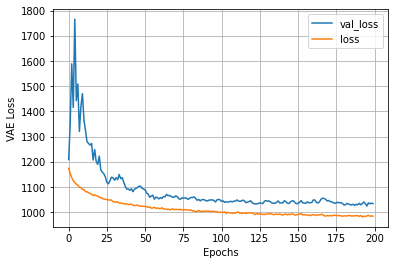

tracking <tf.Variable 'Variable_20:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_20 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_20.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 3s 19ms/step - loss: 1177.6453 - val_loss: 1236.0005
Epoch 2/200
157/157 [==============================] - 0s 414us/step - loss: 1155.3205 - val_loss: 1507.4849
Epoch 3/200
157/157 [==============================] - 0s 383us/step - loss: 1136.7846 - val_loss: 1842.3268
Epoch 4/200
157/157 [==============================] - 0s 380us/step - loss: 1122.2149 - val_loss: 1937.0999
Epoch 5/200
157/157 [==============================] - 0s 355us/step - loss: 1116.2863 - val_loss: 2013.4266
Epoch 6/200
157/157 [==============================] - 0s 389us/step - loss: 1108.3265 - val_loss: 2264.5505
Epoch 7/200
157/157 [==============================] - 0s 459us/step - loss: 1106.6974 - val_loss: 2160.6475
Epoch 8/200
157/157 [==============================] - 0s 420us/step - loss: 1097.8368 - val_loss: 1972.7955
Epoch 9/200
157/157 [==============================] - 0s 385us/step - loss: 1096.07

<Figure size 432x288 with 0 Axes>

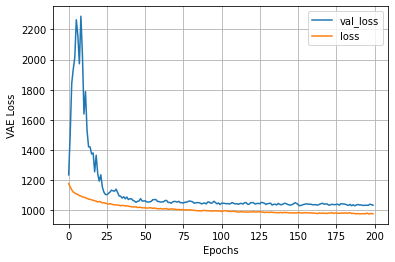

tracking <tf.Variable 'Variable_21:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_21 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_21.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 3s 20ms/step - loss: 1178.5691 - val_loss: 1207.7012
Epoch 2/200
157/157 [==============================] - 0s 499us/step - loss: 1154.1414 - val_loss: 1435.4263
Epoch 3/200
157/157 [==============================] - 0s 402us/step - loss: 1133.6467 - val_loss: 1720.6584
Epoch 4/200
157/157 [==============================] - 0s 404us/step - loss: 1120.9688 - val_loss: 2535.6138
Epoch 5/200
157/157 [==============================] - 0s 606us/step - loss: 1114.0791 - val_loss: 2599.6655
Epoch 6/200
157/157 [==============================] - 0s 400us/step - loss: 1106.7083 - val_loss: 2743.3733
Epoch 7/200
157/157 [==============================] - 0s 426us/step - loss: 1099.7890 - val_loss: 2380.1584
Epoch 8/200
157/157 [==============================] - 0s 377us/step - loss: 1096.7666 - val_loss: 2181.6357
Epoch 9/200
157/157 [==============================] - 0s 361us/step - loss: 1088.38

<Figure size 432x288 with 0 Axes>

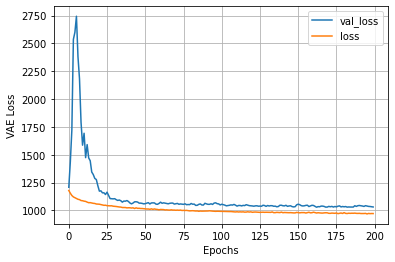

tracking <tf.Variable 'Variable_22:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_22 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_22.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 3s 21ms/step - loss: 1181.7716 - val_loss: 1265.6998
Epoch 2/200
157/157 [==============================] - 0s 457us/step - loss: 1154.8664 - val_loss: 1829.4783
Epoch 3/200
157/157 [==============================] - 0s 404us/step - loss: 1133.9677 - val_loss: 2374.5947
Epoch 4/200
157/157 [==============================] - 0s 432us/step - loss: 1122.2304 - val_loss: 2731.7424
Epoch 5/200
157/157 [==============================] - 0s 413us/step - loss: 1114.5320 - val_loss: 6454.8965
Epoch 6/200
157/157 [==============================] - 0s 452us/step - loss: 1108.5954 - val_loss: 2640.7773
Epoch 7/200
157/157 [==============================] - 0s 488us/step - loss: 1097.8563 - val_loss: 2114.5439
Epoch 8/200
157/157 [==============================] - 0s 452us/step - loss: 1091.5006 - val_loss: 2141.6494
Epoch 9/200
157/157 [==============================] - 0s 442us/step - loss: 1085.64

<Figure size 432x288 with 0 Axes>

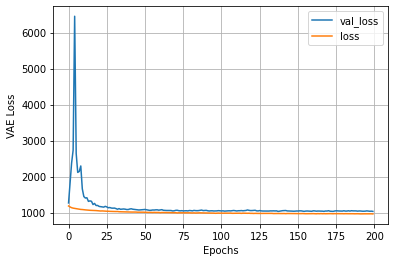

tracking <tf.Variable 'Variable_23:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_23 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_23.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 3s 22ms/step - loss: 1190.1601 - val_loss: 1337.8129
Epoch 2/200
157/157 [==============================] - 0s 508us/step - loss: 1156.2221 - val_loss: 1668.3358
Epoch 3/200
157/157 [==============================] - 0s 456us/step - loss: 1132.8469 - val_loss: 2165.3047
Epoch 4/200
157/157 [==============================] - 0s 484us/step - loss: 1120.8683 - val_loss: 2455.4331
Epoch 5/200
157/157 [==============================] - 0s 459us/step - loss: 1112.5717 - val_loss: 2683.4084
Epoch 6/200
157/157 [==============================] - 0s 483us/step - loss: 1103.5722 - val_loss: 2646.1025
Epoch 7/200
157/157 [==============================] - 0s 526us/step - loss: 1094.3718 - val_loss: 2180.7856
Epoch 8/200
157/157 [==============================] - 0s 473us/step - loss: 1090.5074 - val_loss: 2084.0833
Epoch 9/200
157/157 [==============================] - 0s 563us/step - loss: 1086.27

<Figure size 432x288 with 0 Axes>

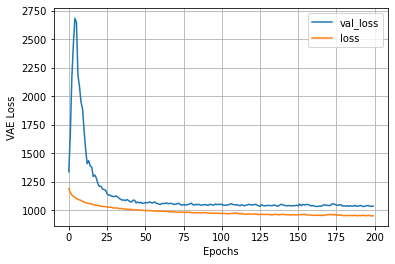

tracking <tf.Variable 'Variable_24:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_24 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_24.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 4s 23ms/step - loss: 1189.2251 - val_loss: 1302.2325
Epoch 2/200
157/157 [==============================] - 0s 537us/step - loss: 1158.9849 - val_loss: 1560.9341
Epoch 3/200
157/157 [==============================] - 0s 509us/step - loss: 1138.4065 - val_loss: 2282.0898
Epoch 4/200
157/157 [==============================] - 0s 586us/step - loss: 1124.4303 - val_loss: 2561.0222
Epoch 5/200
157/157 [==============================] - 0s 496us/step - loss: 1110.0648 - val_loss: 2308.1963
Epoch 6/200
157/157 [==============================] - 0s 558us/step - loss: 1103.9288 - val_loss: 2555.0676
Epoch 7/200
157/157 [==============================] - 0s 503us/step - loss: 1095.5840 - val_loss: 2236.7559
Epoch 8/200
157/157 [==============================] - 0s 507us/step - loss: 1088.0341 - val_loss: 2081.9854
Epoch 9/200
157/157 [==============================] - 0s 481us/step - loss: 1082.42

<Figure size 432x288 with 0 Axes>

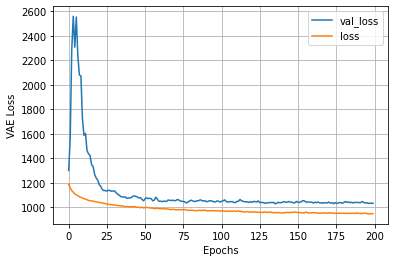

tracking <tf.Variable 'Variable_25:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_25 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_25.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 4s 24ms/step - loss: 1194.7889 - val_loss: 1291.6348
Epoch 2/200
157/157 [==============================] - 0s 624us/step - loss: 1159.4961 - val_loss: 1975.0905
Epoch 3/200
157/157 [==============================] - 0s 503us/step - loss: 1136.0000 - val_loss: 3406.0034
Epoch 4/200
157/157 [==============================] - 0s 488us/step - loss: 1120.1858 - val_loss: 3622.4929
Epoch 5/200
157/157 [==============================] - 0s 495us/step - loss: 1110.0587 - val_loss: 2621.4382
Epoch 6/200
157/157 [==============================] - 0s 535us/step - loss: 1102.0230 - val_loss: 2366.8906
Epoch 7/200
157/157 [==============================] - 0s 567us/step - loss: 1094.0804 - val_loss: 2490.6321
Epoch 8/200
157/157 [==============================] - 0s 522us/step - loss: 1086.9217 - val_loss: 2124.9353
Epoch 9/200
157/157 [==============================] - 0s 512us/step - loss: 1077.47

<Figure size 432x288 with 0 Axes>

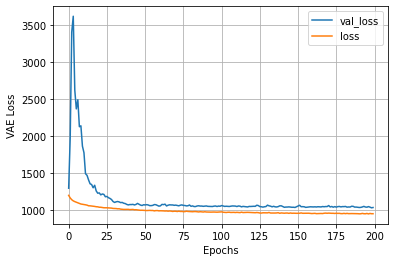

tracking <tf.Variable 'Variable_26:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_26 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_26.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 4s 25ms/step - loss: 1199.3804 - val_loss: 1403.0298
Epoch 2/200
157/157 [==============================] - 0s 552us/step - loss: 1163.2966 - val_loss: 2568.5063
Epoch 3/200
157/157 [==============================] - 0s 474us/step - loss: 1137.9303 - val_loss: 3636.7795
Epoch 4/200
157/157 [==============================] - 0s 495us/step - loss: 1124.7137 - val_loss: 3162.8984
Epoch 5/200
157/157 [==============================] - 0s 565us/step - loss: 1112.6871 - val_loss: 3876.8550
Epoch 6/200
157/157 [==============================] - 0s 490us/step - loss: 1100.8803 - val_loss: 2749.1282
Epoch 7/200
157/157 [==============================] - 0s 534us/step - loss: 1093.8194 - val_loss: 2277.1016
Epoch 8/200
157/157 [==============================] - 0s 509us/step - loss: 1087.5265 - val_loss: 2157.7375
Epoch 9/200
157/157 [==============================] - 0s 502us/step - loss: 1077.16

<Figure size 432x288 with 0 Axes>

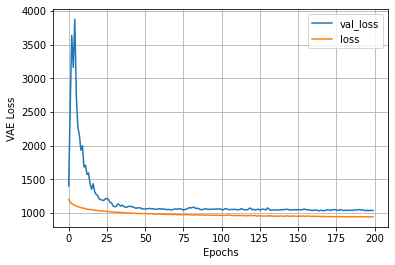

tracking <tf.Variable 'Variable_27:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_27 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_27.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 4s 26ms/step - loss: 1209.8406 - val_loss: 1341.2025
Epoch 2/200
157/157 [==============================] - 0s 638us/step - loss: 1165.4593 - val_loss: 1692.5637
Epoch 3/200
157/157 [==============================] - 0s 576us/step - loss: 1137.6453 - val_loss: 2770.1294
Epoch 4/200
157/157 [==============================] - 0s 677us/step - loss: 1123.1624 - val_loss: 3289.3823
Epoch 5/200
157/157 [==============================] - 0s 535us/step - loss: 1108.8151 - val_loss: 3120.0713
Epoch 6/200
157/157 [==============================] - 0s 596us/step - loss: 1101.2310 - val_loss: 2796.4121
Epoch 7/200
157/157 [==============================] - 0s 569us/step - loss: 1090.5927 - val_loss: 2656.4951
Epoch 8/200
157/157 [==============================] - 0s 585us/step - loss: 1082.0664 - val_loss: 2176.9473
Epoch 9/200
157/157 [==============================] - 0s 612us/step - loss: 1072.08

<Figure size 432x288 with 0 Axes>

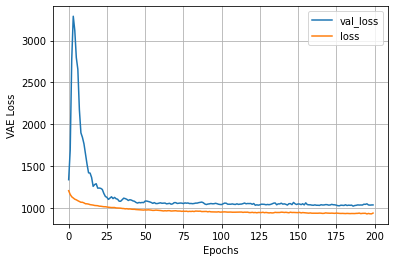

tracking <tf.Variable 'Variable_28:0' shape=() dtype=float32> beta


/tensorflow-1.15.2/python3.6/keras/engine/training_utils.py:819: UserWarning: Output variational_layer_28 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to variational_layer_28.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 157 samples, validate on 18 samples
Epoch 1/200
157/157 [==============================] - 4s 26ms/step - loss: 1217.7292 - val_loss: 1346.9670
Epoch 2/200
157/157 [==============================] - 0s 699us/step - loss: 1165.9813 - val_loss: 1856.9863
Epoch 3/200
157/157 [==============================] - 0s 581us/step - loss: 1138.0308 - val_loss: 2485.1689
Epoch 4/200
157/157 [==============================] - 0s 596us/step - loss: 1123.1731 - val_loss: 2875.7466
Epoch 5/200
157/157 [==============================] - 0s 612us/step - loss: 1109.1961 - val_loss: 3141.7673
Epoch 6/200
157/157 [==============================] - 0s 676us/step - loss: 1098.6710 - val_loss: 3337.0557
Epoch 7/200
157/157 [==============================] - 0s 631us/step - loss: 1089.3477 - val_loss: 2809.3096
Epoch 8/200
157/157 [==============================] - 0s 600us/step - loss: 1081.1841 - val_loss: 2643.4736
Epoch 9/200
157/157 [==============================] - 0s 621us/step - loss: 1071.20

<Figure size 432x288 with 0 Axes>

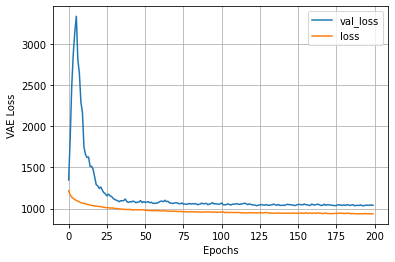

In [11]:
data_type = ["Training", "Testing"]*len(k_list)

df_hist = []
k_list_new = []
encoded_list = []
decoded_list = []
weights_list = []

for latent_dim in k_list:
    vae = Tybalt(original_dim, latent_dim, batch_size=50, epochs=200,
                    learning_rate=0.005, kappa=1, epsilon_std=1.0,
                    beta=K.variable(0), loss='binary_crossentropy',
                    verbose=True)
    vae._build_encoder_layer()
    vae._build_decoder_layer()
    vae._compile_vae()
    vae._connect_layers()

    vae.train_vae(pcos_train_df, pcos_test_df, separate_loss=False)

    plt.figure()
    ax = vae.history_df.plot()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('VAE Loss')
    fig = ax.get_figure()
    plt.grid()
    plt.show()
    fig.savefig("/content/drive/MyDrive/aacb_project/images/vae_latent_"+str(latent_dim)+".png")

    # Append the loss dataframe
    df_hist.append(vae.history_df)

    # Append the encoded and decoded matrix for the training data
    encoded_list.append(vae.encoder.predict(pcos_train_df))
    decoded_list.append(vae.decoder.predict(encoded_list[-1]))
    
    # Append the encoded and decoded matrix for the testing data
    encoded_list.append(vae.encoder.predict(pcos_test_df))
    decoded_list.append(vae.decoder.predict(encoded_list[-1]))

    # Append the weights
    weights_list.append(vae.get_weights()[1])

    k_list_new.append(latent_dim)
    k_list_new.append(latent_dim)

In [12]:
for df,k in zip(df_hist, k_list):
    df.to_csv("/content/drive/MyDrive/aacb_project/data/vae_latent_"+str(k)+".csv")

In [13]:
train_reconstruction = [j for i,j in enumerate(decoded_list) if i%2==0]
test_reconstruction = [j for i,j in enumerate(decoded_list) if i%2==1]

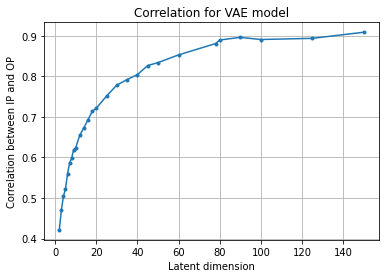

In [33]:
correlation_list_train = []

for array in train_reconstruction:    
    corr = np.corrcoef(pcos_train_df.to_numpy().reshape(-1,), array.reshape(-1,))[0,1]
    correlation_list_train.append(corr)
    
plt.title("Correlation for VAE model")
plt.xlabel("Latent dimension")
plt.ylabel("Correlation between IP and OP")
plt.plot(k_list, correlation_list_train, '.-')
plt.grid()
plt.show()

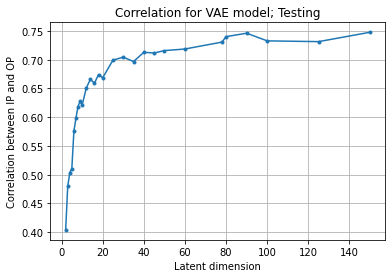

In [20]:
correlation_list_test = []

for array in test_reconstruction:    
    corr = np.corrcoef(pcos_test_df.to_numpy().reshape(-1,), array.reshape(-1,))[0,1]
    correlation_list_test.append(corr)
    
plt.title("Correlation for VAE model; Testing")
plt.xlabel("Latent dimension")
plt.ylabel("Correlation between IP and OP")
plt.plot(k_list, correlation_list_test, '.-')
plt.grid()
plt.show()

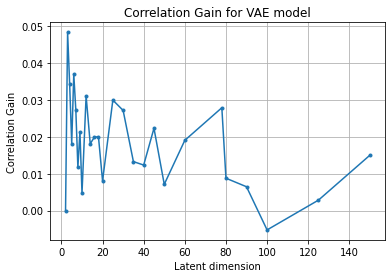

In [32]:
# Correlation gain code
a = correlation_list_train
b = [0]
b.extend(a[:-1])
b = np.array(b)
a = np.array(a)
a[0] = 0
plt.figure()
plt.plot(k_list, a-b, '.-')
plt.grid()
plt.title("Correlation Gain for VAE model")
plt.ylabel("Correlation Gain")
plt.xlabel("Latent dimension")
plt.show()

In [39]:
a = vae.encoder.predict(pcos_train_df)
b = vae.decoder.predict(a)
b.shape

(157, 1668)

In [36]:
sum((b == pcos_train_df).sum())

71

In [41]:
len(data_type)

54

In [44]:
len(vae.get_weights())

2

In [48]:
len(vae.get_weights()[1])

2

In [50]:
len(vae.get_weights()[1][0]),len(vae.get_weights()[1][1])

(150, 1668)

In [53]:
vae.get_weights()[1][0].shape, vae.get_weights()[1][1].shape

((150, 1668), (1668,))

In [55]:
vae.decoder.layers